<a href="https://colab.research.google.com/github/fjpa121197/ml-kinedu-challenge/blob/master/Kinedu_MLE_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comenzar bajando los datasets de Kaggle

In [1]:
import os
# Poner usarname de kaggle para poder trabajar con los datasets
os.environ['KAGGLE_USERNAME'] = "fjpa121197" # username from the json file
os.environ['KAGGLE_KEY'] = "1e5aa0b814add213af2baaab63e5b18a" # key from the json file - remove key after finishing
!kaggle datasets download -d fjpa121197/kineduchallenge

# Extraer el zip file de kaggle
from zipfile import ZipFile
file_name = "/content/kineduchallenge.zip"
with ZipFile(file_name, 'r') as zip_zip:
  zip_zip.extractall()
  print('done')

 61% 33.0M/53.8M [00:00<00:00, 55.3MB/s]
100% 53.8M/53.8M [00:00<00:00, 99.8MB/s]
done


In [23]:
# Import los modulos necesarios
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
import numpy as np
import matplotlib.pyplot as plt


# Espacio para funciones creadas

In [24]:
# Funcion para transformar el data type de las columnas con fechas y hora
def transform_date(df_colum):
    df_colum['Fecha_Retiro'] =  pd.to_datetime(df_colum['Fecha_Retiro'], format='%d/%m/%Y')
    df_colum['Hora_Retiro'] =  pd.to_timedelta(df_colum['Hora_Retiro'], unit= 's')
    df_colum['Fecha_Arribo'] =  pd.to_datetime(df_colum['Fecha_Arribo'], format='%d/%m/%Y')
    df_colum['Hora_Arribo'] =  pd.to_timedelta(df_colum['Hora_Arribo'], unit= 's')

# Funcion para agregar encontrar el numero de arribos por hora y graficarlo
def find_hora_pico(data_set, mes):
  # Encontrar el numero de arribos
  mes_use = data_set[["Hora_Arribo"]] # Solo considerar Hora_Arribo
  mes_use["Hora"] = mes_use.Hora_Arribo.dt.components["hours"] # Ver en que hora es el arribo
  usos = [mes_use[mes_use["Hora"] == x].count()["Hora"] for x in range(0,24)] #Contar el numero de arribos por hora

  #Plotear resultado
  horas = ['%s-%s' %(x,x+1) for x in range(0,24)] # Lista para plotear
  fig = plt.figure(figsize=(12,5))
  ax = fig.add_axes([0,0,1,1])
  plt.xlabel('Hora')
  plt.ylabel('# de Usuarios')
  plt.title("Hora Pico (Arribos) Mes de %s 2019" % (mes))
  ax.bar(horas,usos)
  for i, v in enumerate(usos):
      ax.text(i - 0.4, v + 500, str(v))
  plt.show()
  plt.tight_layout


# Funcion para encontrar las estaciones con más y menos arribos durante el mes 
#Toma como parameters el dataset con las estaciones disponibles, el dataset del mes actual y el mes
def max_min_stations(data_set_stations,data_set, mes):


  estaciones_list = data_set_stations.id.to_list() #Sacar una lista con el ID de las estaciones
  #retiros_list = [data_set[data_set["Ciclo_Estacion_Retiro"] == estacion].count()["Ciclo_Estacion_Retiro"] for estacion in estaciones_list]
  arribos_list = [data_set[data_set["Ciclo_Estacion_Arribo"] == estacion].count()["Ciclo_Estacion_Arribo"] for estacion in estaciones_list]

  # Arribos
  # Ver indices de valor o valores con maximos y minimos
  indices_max = [index for index, value in enumerate(arribos_list) if value == max(arribos_list)]
  indices_min = [index for index, value in enumerate(arribos_list) if value == min(arribos_list)]
  print("Mes de %s 2019" %mes)
  for index in indices_max:
    print("La estación con ID %s tiene la mayor cantidad de viajes (arribos) (%s) " 
          %(str(index + 1), str(max(arribos_list))))
  for index in indices_min:
    print("La estación con ID %s tiene la menor cantidad de viajes (arribos) (%s) " 
          %(str(index + 1), str(min(arribos_list))))
    
  # Retiros
  # Ver indices de valor o valores con maximos y minimos
  """
  indices_max = [index for index, value in enumerate(retiros_list) if value == max(retiros_list)]
  indices_min = [index for index, value in enumerate(retiros_list) if value == min(retiros_list)]

  for index in indices_max:
    print("La estación con ID %s tiene la mayor cantidad de viajes retiros (%s) " 
          %(str(index + 1), str(max(retiros_list))))
  for index in indices_min:
    print("La estación con ID %s tiene la menor cantidad de viajes retiros (%s) " 
          %(str(index + 1), str(min(retiros_list))))
  """

#Sacar la tendencia (%) de la demanda de cada mes por estacion
#Toma como parametros el dataset de estaciones, y los datasets de cada mes.
#Regresa un pandas DataFrame con la columna de crecimiento trimestral.
def tendencia_trim(df_stations, df_ago,df_sept,df_oct):
  tendencia_estaciones = df_stations[["id"]]
  tendencia_estaciones["Retiros_Ago"] = [df_ago[df_ago["Ciclo_Estacion_Retiro"] == x].count()["Ciclo_Estacion_Retiro"] \
                                         for x in range(1,481)]
  tendencia_estaciones["Retiros_Sept"] = [df_sept[df_sept["Ciclo_Estacion_Retiro"] == x].count()["Ciclo_Estacion_Retiro"] \
                                          for x in range(1,481)]
  tendencia_estaciones["Retiros_Oct"] = [df_oct[df_oct["Ciclo_Estacion_Retiro"] == x].count()["Ciclo_Estacion_Retiro"] \
                                         for x in range(1,481)]
  tendencia_estaciones["Crecimiento_Trim"] = (((tendencia_estaciones["Retiros_Sept"] - tendencia_estaciones["Retiros_Ago"]) / tendencia_estaciones["Retiros_Ago"]) \
                                              + ((tendencia_estaciones["Retiros_Oct"] - tendencia_estaciones["Retiros_Sept"]) / tendencia_estaciones["Retiros_Sept"]) \
                                              /2)
  return tendencia_estaciones

def rel_retiros_arribos(df_stations, df_ago, df_sept, df_oct):

    reti_arri = ["Ciclo_Estacion_Retiro","Ciclo_Estacion_Arribo"]
    rel_estaciones = df_stations[["id"]]

    for item in reti_arri:
      if item == "Ciclo_Estacion_Retiro":
        rel_estaciones["Retiros_Agos"] = [df_ago[df_ago[item] == x].count()[item] for x in range(1,481)] 
        rel_estaciones["Retiros_Sept"] = [df_sept[df_sept[item] == x].count()[item] for x in range(1,481)]
        rel_estaciones["Retiros_Oct"] = [df_oct[df_oct[item] == x].count()[item] for x in range(1,481)] 
      else:
        rel_estaciones["Arribos_Agos"] = [df_ago[df_ago[item] == x].count()[item] for x in range(1,481)] 
        rel_estaciones["Arribos_Sept"] = [df_sept[df_sept[item] == x].count()[item] for x in range(1,481)]
        rel_estaciones["Arribos_Oct"] = [df_oct[df_oct[item] == x].count()[item] for x in range(1,481)]

    rel_estaciones["Retiros_Total"] = rel_estaciones["Retiros_Agos"] + rel_estaciones["Retiros_Sept"] + rel_estaciones["Retiros_Oct"]
    rel_estaciones["Arribos_Total"] = rel_estaciones["Arribos_Agos"] + rel_estaciones["Arribos_Sept"] + rel_estaciones["Arribos_Oct"]

    return rel_estaciones

In [5]:
stations_data = pd.DataFrame(pd.read_csv("/content/stations.csv")) # Leer dataset de stations
# Leer datasets para los meses (agosto-octubre)
august_data = pd.DataFrame(pd.read_csv("/content/2019-08.csv"))
sept_data = pd.DataFrame(pd.read_csv("/content/2019-09.csv"))
oct_data = pd.DataFrame(pd.read_csv("/content/2019-10.csv"))

# Transformar el formato de fecha y hora al correcto
transform_date(august_data)
transform_date(sept_data)
transform_date(oct_data)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Listo para comenzar a responder preguntas


# ¿Cómo se comporta el **ARRIBO!!** de viajes por horas del día y por estaciones?

## ¿Cual es la hora pico del servicio? (Arribo de viajes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


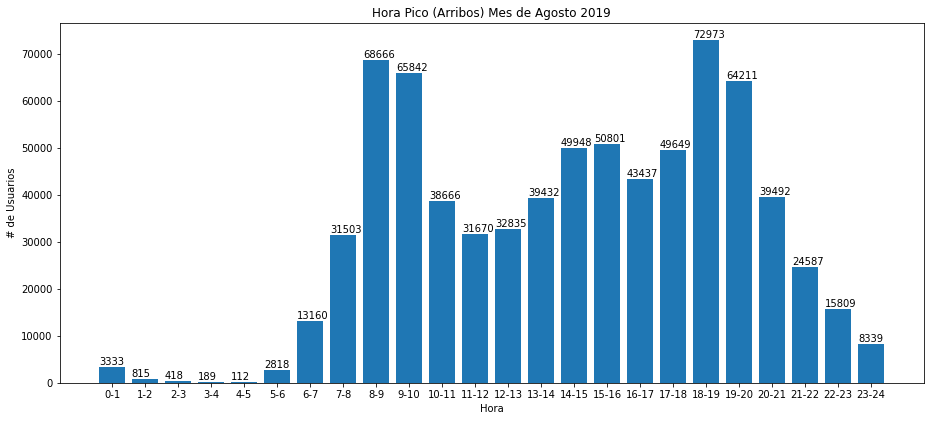

In [6]:
find_hora_pico(august_data, "Agosto")

La hora pico del mes de Agosto es de 18:00 a 19:00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


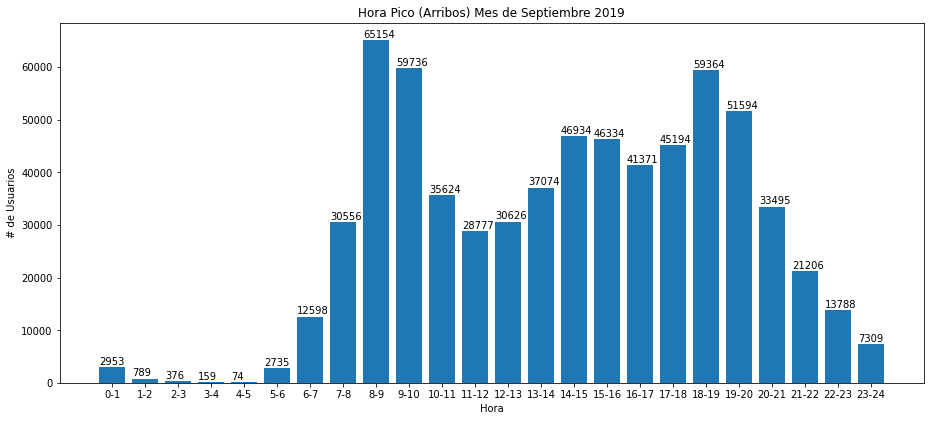

In [8]:
find_hora_pico(sept_data, "Septiembre")

La hora pico del mes de Septiembre es de 8:00 a 9:00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


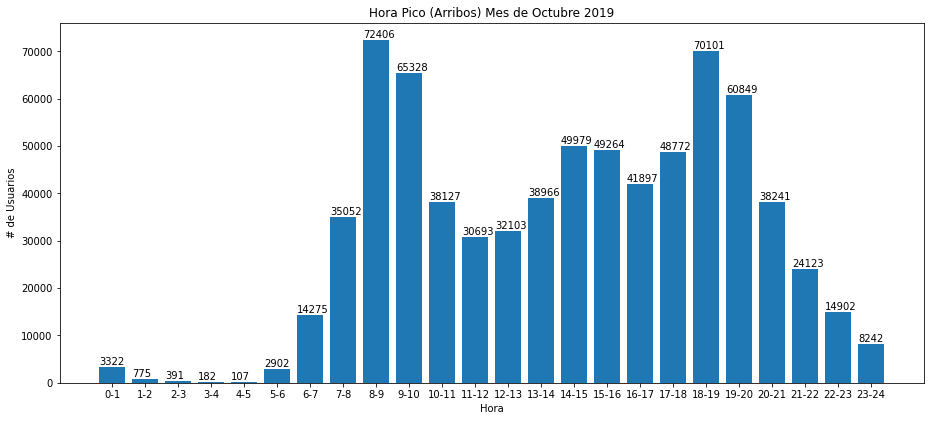

In [9]:
find_hora_pico(oct_data, "Octubre")

La hora pico del mes de Octubre es de 8:00 a 9:00

El comportamiento en los tres meses es muy similar, a excepción del primer mes donde la hora pico es entre 18-19.

## ¿Cúal es la estación con más viajes? ¿y la que menos tiene?

In [10]:
max_min_stations(stations_data,august_data,"Agosto")

Mes de Agosto 2019
La estación con ID 266 tiene la mayor cantidad de viajes (arribos) (8845) 
La estación con ID 156 tiene la menor cantidad de viajes (arribos) (0) 
La estación con ID 442 tiene la menor cantidad de viajes (arribos) (0) 


In [11]:
max_min_stations(stations_data,sept_data,"Septiembre")

Mes de Septiembre 2019
La estación con ID 266 tiene la mayor cantidad de viajes (arribos) (7616) 
La estación con ID 113 tiene la menor cantidad de viajes (arribos) (0) 
La estación con ID 156 tiene la menor cantidad de viajes (arribos) (0) 
La estación con ID 442 tiene la menor cantidad de viajes (arribos) (0) 


In [12]:
max_min_stations(stations_data,oct_data,"Octubre")

Mes de Octubre 2019
La estación con ID 266 tiene la mayor cantidad de viajes (arribos) (8496) 
La estación con ID 17 tiene la menor cantidad de viajes (arribos) (0) 
La estación con ID 101 tiene la menor cantidad de viajes (arribos) (0) 
La estación con ID 113 tiene la menor cantidad de viajes (arribos) (0) 
La estación con ID 156 tiene la menor cantidad de viajes (arribos) (0) 
La estación con ID 442 tiene la menor cantidad de viajes (arribos) (0) 


# Tendencia de estaciones


In [13]:
df_tendencia = tendencia_trim(stations_data,august_data,sept_data,oct_data)
print("Top 3 Estaciones que han incrementado su demanda (a lo largo de los 3 meses): ")
print(" ")
print(df_tendencia.nlargest(3,"Crecimiento_Trim"))
print("\n")
print("Top 3 Estaciones que han descendido su demanda (a lo largo de los 3 meses): ")
print(" ")
print(df_tendencia.nsmallest(3,"Crecimiento_Trim"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Top 3 Estaciones que han incrementado su demanda (a lo largo de los 3 meses): 
 
      id  Retiros_Ago  Retiros_Sept  Retiros_Oct  Crecimiento_Trim
440  441          161           177          328          0.525933
456  457          370           442          583          0.354097
282  283          504           535          696          0.211975


Top 3 Estaciones que han descendido su demanda (a lo largo de los 3 meses): 
 
      id  Retiros_Ago  Retiros_Sept  Retiros_Oct  Crecimiento_Trim
16    17         2734          1230            0         -1.050110
100  101          432           196            0         -1.046296
403  404          985           922           84         -0.518406


**Metodología empleada: Ver el porcentaje de incremento o descenso del mes agosto a septiembre ( esto es valor septiembre - agosto, todo esto entre el valor de agosto), eso me dara un porcentaje de incremento o decremento, despues hacer lo mismo pero ocupando el mes de octubre y septiembre. Despues sumar los dos porcentajes y dividirlo entre dos, para sacar un promedio de incremento o decremento.**


Respuesta: 
Las estaciones con mayor incremento en su demanda (durante los 3 

*   Las estaciones con mayor incremento en su demanda (durante los 3 meses) son estación 441, 457 y 283.

*   Las estaciones con mayor descenso en su demanda (durante los 3 meses) son estación 17, 101 y 404.


# Relación entre retiros y arribos entre estaciones

In [25]:
rel_estaciones = rel_retiros_arribos(stations_data,august_data,sept_data,oct_data)
print(rel_estaciones['Retiros_Total'].corr(rel_estaciones['Arribos_Total']))

0.9596673005081358


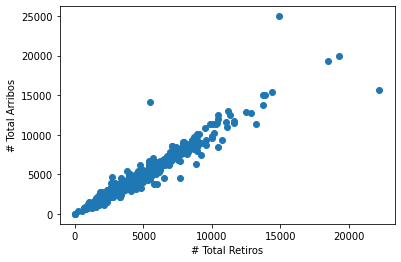

In [26]:
from matplotlib import pyplot

pyplot.scatter(rel_estaciones["Retiros_Total"], rel_estaciones["Arribos_Total"])
pyplot.xlabel("# Total Retiros")
pyplot.ylabel("# Total Arribos")
pyplot.show()


La relación entre los retiros y arribos entre estaciones puede ser interpretada como fuerte, ya que primero la correlación entre arribos y retiros es 0.95, lo cual es señal de relación linear fuerte.

# Segmentación de estaciones

La segmentación sera por el numero de retiros y arribos durante los tres meses (agosto, septiembre y octubre). Se hizo esta segmentación para identificar cuales estaciones son mayormente ocupadas, y cuales no. Se hizo por medio de primero identificar el numero de retiros y arribos, y aplicando K- means Clustering. Pudiera ser valiosa porque se podria identificar que estaciones tienen un flujo menor de retiros y arribos, lo cual podria ser indicio de que la estacion esta fuera de uso, los usuarios no la localizan con facilidad, etc. Tambien, se podria identificar que zonas son las propensas a que un usuario la localice con facilidad.

In [54]:
df_segmentacion = rel_retiros_arribos(stations_data,august_data,sept_data,oct_data)
df_segmentacion = df_segmentacion[["id","Retiros_Total", "Arribos_Total"]]

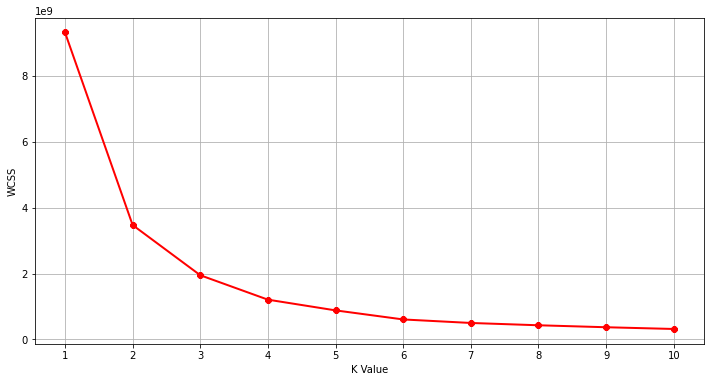

In [57]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_segmentacion.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

El numero que se ocupara para k-means sera 4, ya que despues de este valor, el valor de la suma de errores al cuadrado baja de una forma no tan alta. 




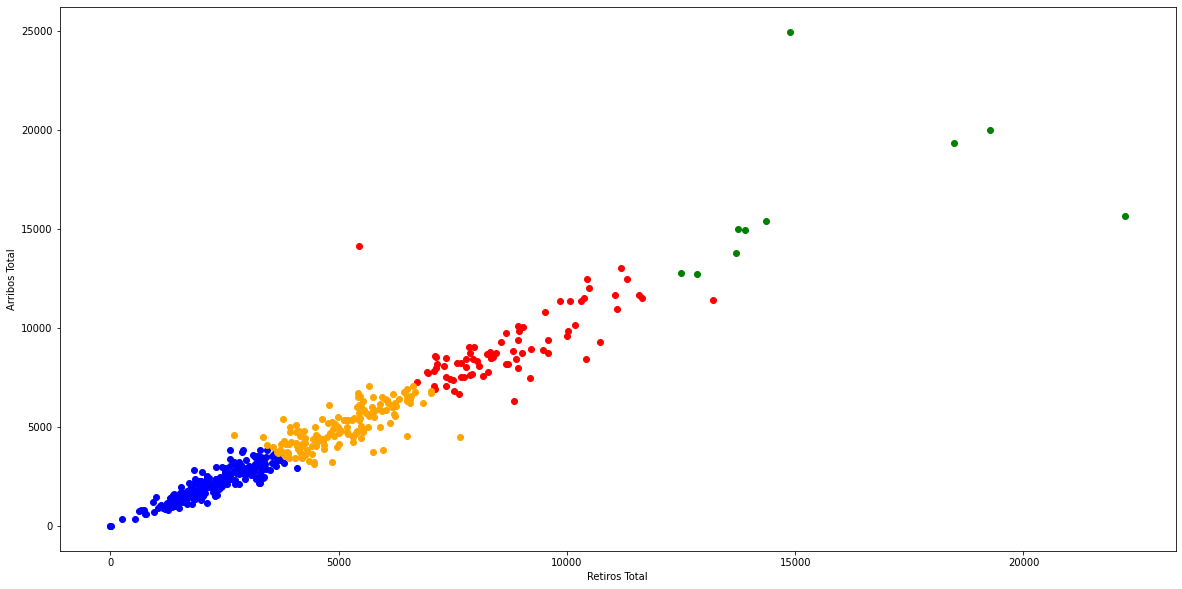

In [63]:
km = KMeans(n_clusters=4)
clusters = km.fit_predict(df_segmentacion.iloc[:,1:])
df_segmentacion["label"] = clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.scatter(df_segmentacion["Retiros_Total"][df_segmentacion.label == 0], \
           df_segmentacion["Arribos_Total"][df_segmentacion.label == 0], c='blue')
ax.scatter(df_segmentacion["Retiros_Total"][df_segmentacion.label == 1], \
           df_segmentacion["Arribos_Total"][df_segmentacion.label == 1], c='red')
ax.scatter(df_segmentacion["Retiros_Total"][df_segmentacion.label == 2],\
           df_segmentacion["Arribos_Total"][df_segmentacion.label == 2], c='green')
ax.scatter( df_segmentacion["Retiros_Total"][df_segmentacion.label == 3], \
           df_segmentacion["Arribos_Total"][df_segmentacion.label == 3], c='orange')
plt.xlabel("Retiros Total")
plt.ylabel("Arribos Total")
plt.show()

El grupo azul, puede ser considerado como las estaciones las cuales su uso es muy bajo, la cantidad de retiros y arribos durante esos tres meses es baja. El grupo amarillo, puede ser considerado como las estaciones que tienen un uso abajo del promedio, pero que los usuarios como quiera ocupan. El siguiente grupo, rojo, son las estaciones con uso arriba del promedio, en el cual el numero de arribos y retiros es alta. Por ultimo, los puntos verdes son las estaciones con más uso.

# Análisis y Segmentación

La forma en que ocuparía este análisis es para identificar las estaciones con mayor uso, y ver si las estaciones que estan alrededor de estas tienen el mismo o similar numero de usos. Esto podria dar a indicar si todo el sector (de estaciones) es ocupado por el usuario de forma similar. De no ser así, podría ser que esas estaciones con bajos numero de retiros y arribos, estan localizadas en lugares no visibles y se podría considerar retirar la estación. Al mismo tiempo, se podría identificar si es necesario poner una estación nueva si es que no hay estaciones cerca y una estación tiene una gran cantidad de arribos y retiros.

Con el análisis de la demanda durante los tres meses, tambien se podría ver que estaciones no incrementan su demanda (y que no esten en 0) y así poder ver si retirar la estación.